<a href="https://colab.research.google.com/gist/jus-tinian/94f091bd342cab75d65b64bbba5e7ef6/ml_factor_investing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Machine Learning Project:

## Machine Learning for Factor Investing

---

## Phase 1 Tasks

- Define the Objective
- Data Acquisition
- Detailed description of dataset
- Exploratory Data Analysis
- Algorithm selection

---
---

## The Objective

The project objective is to use machine learning and the Python programming language to model returns on public equity investments across four labels: 1, 3, 6, and 12 month timeframes. Performance measures in the context of this notebook are in reference to machine learning performance measures, and not performance measures on portfolios or individual equities. This project will likely not attempt to create portfolios from our ML models, as portfolio contstruction is beyond the scope of this course. 

Mainly, the text _Machine Learning for Factor Investing_ (MLFI) by Tony Guida and Dr. Guillaume Coqueret will be used as a guide for developing our models. MLFI will primarily be supplemented by Dr. Yves Hilpisch's _Python for Finance 2d ed_ (PyFi) chapter 13. Finally, Dr. Marcos Lopez de Prado's _Advances in Financial Machine Learning_ (AFML) will be used to aid in hyperparameter tuning with cross validation. AFML will also be referenced for our work with Random Forests. 

MLFI is written in the R programming language, PyFi is written in Python 3, and AFML is written in Python 2; this project will translate R to Python code, and use Python 3 and scikit-learn (SKL) machine learning library. Additional libraries to be used are: Pandas, Numpy, and Matplotlib.

_Main References:_
- Machine Learning for Factor Investing, Tony Guida and Guillaume Coqueret: http://www.mlfactor.com/
- Machine Learning for Asset Managers, Dr. Marcos Lopez de Prado
- Advances in Financial Machine Learning, Dr. Marcos Lopez de Prado
- Python for Finance, 2d ed., Dr. Yves Hilpisch
- Scikit-learn: https://scikit-learn.org/stable/

_Supplemental References:_
- Machine Learning for Finance, Dixon et al
- Quantum Finance, Raymond S.T. Lee
- Machine Learning for Financial Market Prediction — Time Series Prediction With Sklearn and Keras
 - https://alphaarchitect.com/2018/06/05/machine-learning-financial-market-prediction-time-series-prediction-sklearn-keras/
- Machine Learning Classification Methods and Factor Investing
 - https://alphaarchitect.com/2018/12/21/machine-learning-classification-methods-and-factor-investing/



---
---

## The Data

**_Acquisition_** <br>

The original data was retrieved from https://github.com/shokru/mlfactor.github.io/blob/master/material/data_ml.RData as an RData file and converted to CSV. The data has been placed onto Kaggle for use by other students and machine learning enthusiasts: https://www.kaggle.com/jgoheen/machine-learning-for-factor-investing

**_Description_** <br>

The data consists of 99 columns - including the stock ID (company) and date, partitioned into the metric-families shown below:

* valuation (earning yields, accounting ratios)
* profitability and quality (return on equity)
* momentum and technical analysis (past returns, relative strength index)
* risk (volatilities)
* estimates (earnings-per-share) 
* volume and liquidity (share turnover)

There are 1207 companies covered across 21 years, from November 1998 to March 2019. Not all 1207 have data available across the entire 245 month span, as shown in the below plot.

The first 2 columns are stock_id and date, and are not used as features.

Columns 3 - 95 are the model features. 

Columns 96-99 are the target variables (labels). The label names are:

* R1M_Usd: return forward 1 month <br>
* R3M_Usd: return forward 3 months <br>
* R6M_Usd: return forward 6 months <br>
* R12M_Usd: return forward 12 months <br>

The raw data comprises of 268336 rows.

The features are all continuous data. There are no initial categorical features. The stock_id column is a cardinal ID of the firm's name. The firm name is not included in the dataset; meaning no investment strategies can be developed directly from this dataset.

The features data was scaled by the authors using uniformization. 

> uniformization: $\tilde{x}_i=F_X(x_i)$, where $F_X$ is the empirical cumulative distribution function of $X$. In this case, the vector $\tilde{X}$ is defined to follow a uniform distribution over [0,1]

The labels appear to have not been scaled (shown in EDA section).

A data dictionary is provided in the Preprocessing and EDA section of this notebook and a full description of columns (dates, identifiers, features, and labels) can be found at: http://www.mlfactor.com/data-description.html

In [ ]:
# generic imports
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# set option to display all rows for certain EDA methods
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 500)

In [ ]:
# get data
df = pd.read_csv('mlfi.csv', index_col="Unnamed: 0")

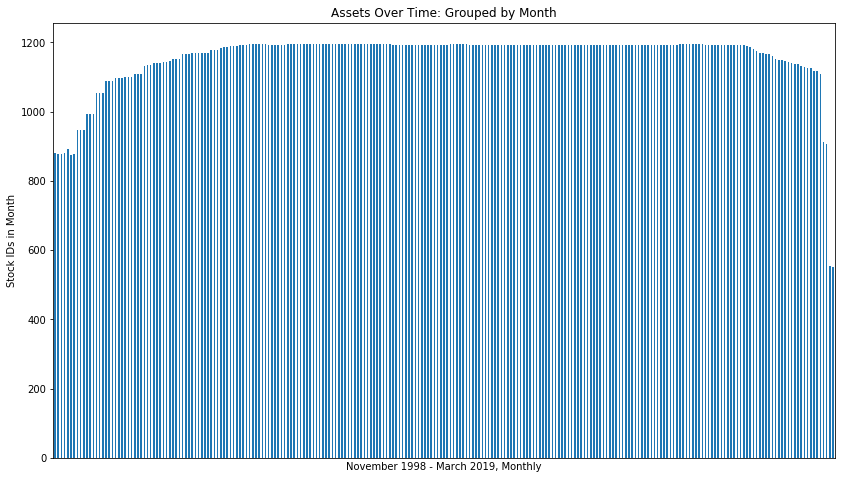

In [ ]:
# plot assets over time
df.groupby('date').count()['stock_id'].plot(kind='bar', figsize=(14, 8))
plt.xticks([])
plt.title("Assets Over Time: Grouped by Month")
plt.xlabel("November 1998 - March 2019, Monthly")
plt.ylabel("Stock IDs in Month");

---
---

## Preprocessing and Exploratory Data Analysis

**_Preprocessing_**

An amount of preprocessing and filtering was necessary prior to exploratory data analysis, as certain tasks - plotting a scatter matrix or histogram of all columns - proved intensive for a DataFrame of 99 columns. 

The first step in preprocessing was to download the file from Github, and convert from an RData file to a CSV file so the data-file could be used with Python programs.

The data does not contain any missing values. As mentioned above, the features are all continuous data and there are no categorical text features. 

I've decided to drop the stock_ids which do not have data for all 21 years. The max available months when grouped-by stock_id is 245 months. The below shown code reduces the data to those stock IDs which have 245 available months. Resulting in 372 stocks being available for the project.

The text supplies a short list of features to use: 

* "Div_Yld": divdend yield
* "Eps": earnings per share
* "Mkt_Cap_12M_Usd": 12 month market capitilization, reported in U.S. Dollars
* "Mom_11M_Usd": price momentum 12 - 1 months in USD
* "Ocf": operating cash flow
* "Pb": price to book ratio
* "Vol1Y_Usd": volatility of returns over one year

We will use this list object - features_short - for our EDA in this notebook. Given features_short focuses on features which provide data aggregated for 11 or 12 months, the label we will use in our initial univariate models will be 'R12M_Usd': return forward 12 months.

Given the amount of columns, we refrain from printing to screen a full .info or .describe and instead filter on select columns for brevity. Multiple Pandas EDA methods have been combined into this DataFrame: info() as dtypes.values, describe(), and null counts.

- - -
Define lists for non-features, features, features_short, and labels; and filter the DataFrame

In [ ]:
# lists for filtering
non_features = ['date', 'stock_id']
labels = ['R1M_Usd', 'R3M_Usd', 'R6M_Usd', 'R12M_Usd']
features = [i for i in df.columns if i not in non_features+labels]
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]
labels_short = ['R12M_Usd']
eda_columns = non_features + features_short + labels_short
eda_features_label = features_short + labels_short

In [ ]:
# get filtered list of stock_ids; print max number of months available and the number of unique stock IDs after filtering
max_time_view = df.groupby('stock_id').count().sort_values('date', ascending=False)
print('-The maximum number of available months is: ', max_time_view['date'].max())
max_time_view = max_time_view.loc[max_time_view.date == 245, :]
# get list of stock_ids with 245 months available
max_time_view_stock_ids = max_time_view.index.tolist()
max_time_view_stock_ids.sort()
print('-There will %d stocks covered after filtering' %len(max_time_view_stock_ids))

-The maximum number of available months is:  245
-There will 372 stocks covered after filtering


In [ ]:
# filter to stock_ids with 245 available months
df = df[eda_columns].loc[df.stock_id.isin(max_time_view_stock_ids), :].reset_index().drop('index', axis= 1).sort_values('stock_id')

---

**_Exploratory Data Analysis_**

**Data Dictionary**

Multiple Pandas EDA methods have been combined into this DataFrame: info() as dtypes.values, describe(), and null counts.

The data was described above in the description section, and we refrain from repeating here.

In [ ]:
# get data description
data_dictionary = pd.read_csv('mlfactor_data_desc.csv')
# filter to EDA columns
data_dictionary = data_dictionary.loc[data_dictionary['Column Name'].isin(eda_columns), :]
# get dtypes
data_dictionary['_dtypes'] = df.dtypes.values
# get notnull values counts
data_dictionary['non-null'] = df.notnull().count().values
# call describe() and join to data_dictionary
data_dictionary = data_dictionary.join(df.describe(include='all').T, on='Column Name')
# get null count
data_dictionary['null_count'] = data_dictionary['non-null'] - data_dictionary['count']
# drop unwanted columns
data_dictionary = data_dictionary.drop(['unique', 'top', 'freq'], axis=1)
# show data_dictionary
data_dictionary

,Column Name,Short Description,_dtypes,non-null,count,mean,std,min,25%,50%,75%,max,null_count
0,stock_id,security id,object,91140,91140,569.18,347.389,3,277,534,836.25,1210,0
1,date,date of the data,int64,91140,91140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
14,Div_Yld,dividend yield,float64,91140,91140,0.533511,0.296181,0.01,0.27,0.56,0.8,1,0
21,Eps,earnings per share,float64,91140,91140,0.472142,0.263564,0.01,0.26,0.46,0.68,1,0
42,Mkt_Cap_12M_Usd,average market capitalization over 12 months in USD,float64,91140,91140,0.304373,0.184114,0.01,0.15,0.29,0.44,0.98,0
45,Mom_11M_Usd,price momentum 12 - 1 months in USD,float64,91140,91140,0.496133,0.28209,0.01,0.26,0.49,0.74,1,0
60,Ocf,operating cash flow,float64,91140,91140,0.33644,0.191539,0.01,0.18,0.32,0.48,0.99,0
72,Pb,price to book,float64,91140,91140,0.428903,0.264067,0.01,0.21,0.41,0.62,1,0
93,Vol1Y_Usd,volatility of returns over one year,float64,91140,91140,0.506152,0.276881,0.01,0.27,0.5,0.74,1,0
98,R12M_Usd,return forward 12 months (LABEL),float64,91140,91140,0.131113,0.664709,-0.968,-0.092,0.067,0.269,72.24,0


--- 
**Correlation Matrix**

Based on highest positive correlation with our label (R12M_Usd), the feature `Vol1Y_Usd` appears promising. Based on lowest negative correlation with the label, the feature `Mkt_Cap_12M_Usd` also appears promising. Meaning, we should expect those stock_ids with the lowest market cap, and highest volatility to perform best.


In [ ]:
# plot correlation matrix for filtered dataframe
# we can ignore stock_id
# the label is R12M_Usd
df[eda_features_label].corr().style.background_gradient().set_precision(4)

,Div_Yld,Eps,Mkt_Cap_12M_Usd,Mom_11M_Usd,Ocf,Pb,Vol1Y_Usd,R12M_Usd
Div_Yld,1,0.1784,0.04487,-0.06765,0.1083,-0.1256,-0.4179,-0.03717
Eps,0.1784,1,0.3289,0.04931,0.3228,0.008932,-0.3383,-0.08585
Mkt_Cap_12M_Usd,0.04487,0.3289,1,0.0006681,0.6864,0.3026,-0.2158,-0.09762
Mom_11M_Usd,-0.06765,0.04931,0.0006681,1,0.02168,0.1274,-0.1229,-0.08353
Ocf,0.1083,0.3228,0.6864,0.02168,1,0.03291,-0.2204,-0.04586
Pb,-0.1256,0.008932,0.3026,0.1274,0.03291,1,0.0596,-0.06619
Vol1Y_Usd,-0.4179,-0.3383,-0.2158,-0.1229,-0.2204,0.0596,1,0.06601
R12M_Usd,-0.03717,-0.08585,-0.09762,-0.08353,-0.04586,-0.06619,0.06601,1


---
**Histograms**

As we can see below, the authors of the dataset have already scaled the dataset so as to prepare for machine learning problems. It should be noted the features are all on scale of 0 to 1 and the label is of a scale not bounded by 1. Additionally, there appears to be an extreme outlier in the label, as the data appears heavily positively skewed.

The book (MLFI) states the data has been 'uniformized'. On further reading, the authors have scaled the data with uniformization (Ch 5 Section 4). The equivalent sklearn scaling method appears to be sklearn.preprocessing.quantile_transform (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.quantile_transform.html).

Some features appears to remain positively skewed. Further reading of the references is required so as to determine proper methods of handling skewness with respect to this specific type of financial data.

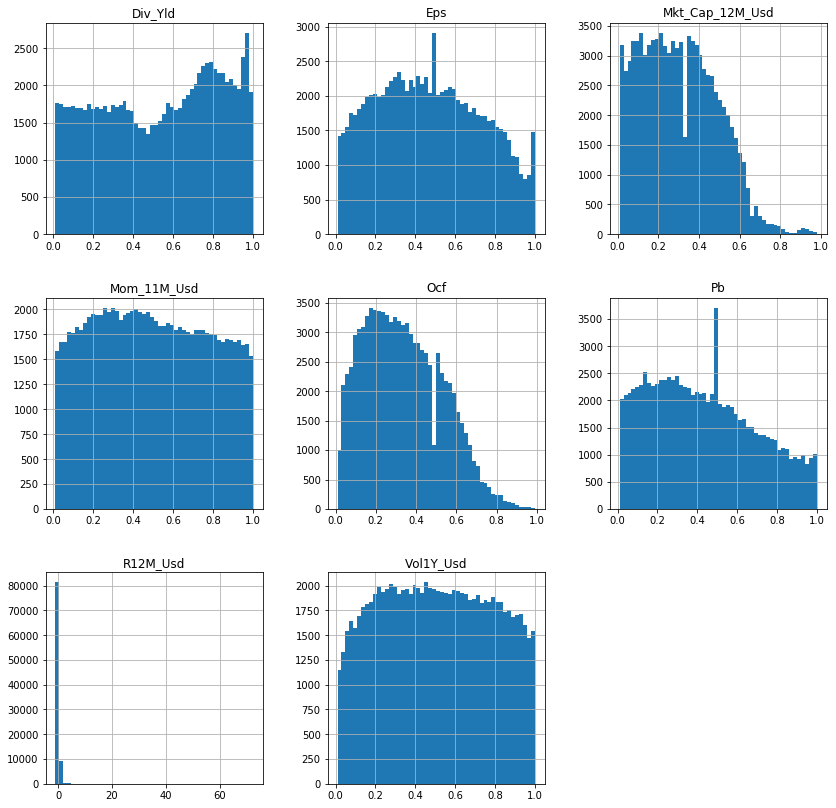

In [ ]:
# plot a histogram for each numerical attribute to get a feel of data
%matplotlib inline
import matplotlib.pyplot as plt
df[eda_features_label].hist(bins=50, figsize=(14,14))
plt.show()

---
**Scatter Matrix**

Dividend Yield and Earnings Per Share show negative correlations - implying the lower the dividend-yield or EPS, the higher the return.

All other features Mkt_Cap_12M_Usd, Mom_11M_Usd, Ocf, and Pb all share similar appearance or correlations as dividend yield and EPS; however these results are less intuitive than dividend yield and EPS, and explanations are saved for Phase 2 of the project.

Vol1Y_Usd exhibits the only positive relationship. However, higher volatility means an increase in risk. Where risk is defined as losses. Risk averse investors may consider this universe of stock_ids as not desirable given the correlation of high risk with higher returns.

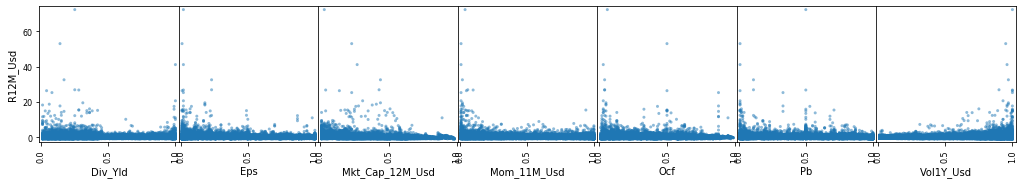

In [ ]:
# gather plots in object
axes = pd.plotting.scatter_matrix(df[eda_features_label], figsize=(20, 20));

# filter through and hide all but label's row
for i in range(len(axes)):
    # condition if y variable is price
    # hide the plot for (x=price, y=price)
    if i == len(axes)-1:
        for j in range(len(axes)):
            if j == len(axes)-1:
                axes[i,j].set_visible(False)
    # hide all other (x=sm_data[0:-1], y=other index values)
    elif i != len(axes)-1:
        for j in range(len(axes)):
            # hide the plot
            axes[i,j].set_visible(False)

---
---

## Algorithm Selection

**_Algorithm Selection_**

Our algorithm selection will be limited to supervised learning algorithms. Additionally, our models are multivariate regressors. According to the MLFI text "The original labels (future returns) are numerical and will be used for regression exercises, that is, when the objective is to predict a scalar real number". Meaning, if we are to create classifiers, we must create categorical features based on buy, hold (or no position), or sell (short the stock) cardinal indicators (-1 -> short, 0 -> no position, 1 -> long [buy]). 

The book, Machine Learning for Factor Investing, covers the following supervised machine learning algorithm types in depth, devoting a chapter to each: tree based networks, neural networks, support vector machines, and bayseian methods. Python for Finance covers Decision Tree classifiers, Logistic Regression, and Gaussian Naive Bayes classification. We will use the following algorithms, where our initial focus are multivariate regression models:

* Random Forests:
    * MLFI: http://www.mlfactor.com/trees.html
    * SKL:  
     - Regression: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

* Support Vector Machines: 
    * MLFI: http://www.mlfactor.com/svm.html
    * SKL:
     - Regression: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
* Bayesian Methods: 
    * MLFI: http://www.mlfactor.com/bayes.html
    * SKL:  
     - Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge
* Logistic Regression
    * SKL:
     - Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html